In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

c:\Users\Bruger\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Step 1: Load and Preprocess the Dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten images
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)


# Step 2: LSH Projection
def lsh_projection(X, num_bits):
    """
    Project the data using LSH.
    :param X: Input data (n_samples, n_features)
    :param num_bits: Number of hash bits for LSH
    :return: Hash codes
    """
    np.random.seed(42)  # For reproducibility
    random_projection = np.random.randn(X.shape[1], num_bits)
    hash_codes = np.dot(X, random_projection) > 0  # Binary hash codes
    return hash_codes.astype(int)

num_bits = 32  # Number of hash bits
train_hashes = lsh_projection(x_train, num_bits)
test_hashes = lsh_projection(x_test, num_bits)

# Step 3: Evaluation using MAP and Precision@K
def calculate_hamming_distance(hash1, hash2):
    """Calculate the Hamming distance between two binary hash codes."""
    return np.sum(hash1 != hash2)

def precision_at_k(retrieved_labels, true_label, k):
    """Calculate precision at K."""
    return np.sum(retrieved_labels[:k] == true_label) / k

def evaluate(test_hashes, train_hashes, y_test, y_train, max_k=50):
    """Evaluate the model using MAP and precision at K for k = 1,...,max_k."""
    map_score = 0
    precision_at_k_scores = np.zeros(max_k)  # Initialize array to store precision at each k
    
    for i in range(len(test_hashes)):
        # Compute Hamming distances between test sample and all training samples
        distances = np.array([calculate_hamming_distance(test_hashes[i], train_hashes[j]) for j in range(len(train_hashes))])
        
        # Sort indices of training samples based on distance
        sorted_indices = np.argsort(distances)
        
        # Retrieve sorted labels
        retrieved_labels = y_train[sorted_indices]
        
        # Calculate precision at each K up to max_k
        for k in range(1, max_k + 1):
            precision_at_k_scores[k-1] += precision_at_k(retrieved_labels, y_test[i], k)
        
        # Calculate Average Precision (AP) for MAP
        relevant = (retrieved_labels == y_test[i])
        if np.sum(relevant) == 0:
            continue
        ap = np.mean([np.mean(relevant[:j+1]) for j in range(len(relevant)) if relevant[j]])
        map_score += ap

    map_score /= len(test_hashes)
    precision_at_k_scores /= len(test_hashes)

    return map_score, precision_at_k_scores

# Evaluate for k = 1,...,50
max_k = 50
map_score, precision_at_k_scores = evaluate(test_hashes, train_hashes, y_test, y_train, max_k)

# Display results for each K
print(f"Mean Average Precision (MAP): {map_score:.4f}")
for k in range(1, max_k + 1):
    print(f"Precision at K (P@{k}): {precision_at_k_scores[k-1]:.4f}")


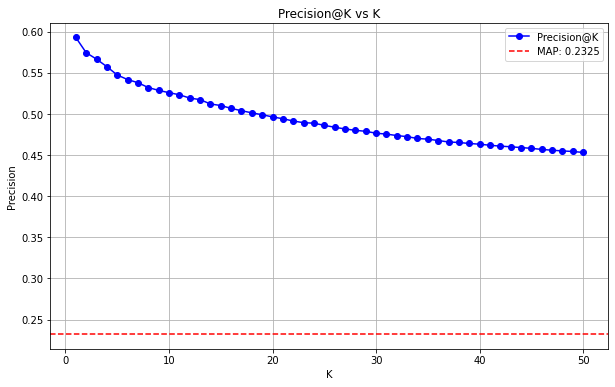

In [3]:
import matplotlib.pyplot as plt

# Plot Precision@K for K = 1 to 50
plt.figure(figsize=(10, 6))
ks = np.arange(1, max_k + 1)
plt.plot(ks, precision_at_k_scores, marker='o', linestyle='-', color='b', label='Precision@K')

# Plot horizontal line for MAP
plt.axhline(y=map_score, color='r', linestyle='--', label=f'MAP: {map_score:.4f}')

# Add titles and labels
plt.title('Precision@K vs K')
plt.xlabel('K')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()
